# AutoDecoders on the ModelNet 10 data

### Change directory to kaolin

The kaolin library must be downloaded from <https://github.com/NVIDIAGameWorks/kaolin> and installed with instructions from their README

### Note: The setenv.sh script must be run to set up proper kaolin paths

In [1]:
# import necessary libraries
import kaolin as kal
from kaolin.datasets import modelnet
from torch.utils.data import DataLoader
from torchvision import transforms

import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from utils import visualize_npy
from functools import partial

%matplotlib inline

   No module named 'nuscenes'
   None


Traceback (most recent call last):
  File "/home/mmvc/.conda/envs/sms1198_env/lib/python3.7/site-packages/kaolin-0.1.0-py3.7-linux-x86_64.egg/kaolin/datasets/__init__.py", line 11, in <module>
    from .nusc import NuscDetection
  File "/home/mmvc/.conda/envs/sms1198_env/lib/python3.7/site-packages/kaolin-0.1.0-py3.7-linux-x86_64.egg/kaolin/datasets/nusc.py", line 21, in <module>
    from nuscenes.utils.geometry_utils import transform_matrix
ModuleNotFoundError: No module named 'nuscenes'


## Kaolin mesh to point cloud conversion functions

In [2]:
def convert_mesh_to_pt_cloud(mesh, num_points=5000):
    return kal.conversions.trianglemesh_to_pointcloud(mesh, num_points)[0]

In [3]:
modelnet10_category_list = ['bathtub', 'bed',        'chair',  'desk',  'dresser',
                            'monitor', 'night_stand', 'sofa',  'table',  'toilet']

modelnet40_category_list = ['airplane', 'bench', 'bowl', 'cone', 'desk', 'flower_pot', 'keyboard', 'mantel', 'person', 'radio',
                            'sofa', 'table', 'tv_stand', 'xbox', 'bathtub', 'bookshelf', 'car', 'cup', 'door', 'glass_box', 'lamp', 'monitor',
                            'piano', 'range_hood', 'stairs', 'tent', 'vase', 'bed', 'bottle', 'chair', 'curtain', 'dresser',
                            'guitar', 'laptop', 'night_stand', 'plant', 'sink', 'stool', 'toilet', 'wardrobe']

### Loads the `.off` files from ModelNet as torch.Tensors and saves them as `.npy` files for faster loading

In [9]:
def unload_off_to_npy(category_list, split='train', src_dir='./data/ModelNet10/', dump_npy_dir='./data/ModelNet10_train_npy/'):
    for category in category_list:
        dump_npy_file = 'modelnet_'+category+'.npy'
        npy_dump_file = Path(dump_npy_dir+dump_npy_file)
        if npy_dump_file.is_file():
            print(f"{dump_npy_dir+dump_npy_file} already exists. Skipping now")
            continue

        print(f"Unloading {category} to npy")
        mdnet = modelnet.ModelNet(root=src_dir, categories=[category], split=split,
                                  transform=transforms.Compose([convert_mesh_to_pt_cloud]))
        print(len(mdnet))
        # data_loader = DataLoader(mdnet, batch_size=1,
        #                         shuffle=True, num_workers=0)
        X = None
        # Load the entire .off files into one Tensor object X one at a time
        for i in range(len(mdnet)):
            try:
                if X is None:
                    X = mdnet[i][0].unsqueeze(0)
                else:
                    X = torch.cat([X, mdnet[i][0].unsqueeze(0)], dim=0)
            except Exception as e:
                print(e)
                print(f"Skipped {i}")
            if i % 20:
                if X is not None:
                    print(X.shape)

        dump_npy_file = 'modelnet_'+category+'.npy'
        if X is not None:
            np.save(dump_npy_dir+dump_npy_file, X.numpy())
            print(
                f"Dumped category {category} with shape {X.shape} under {dump_npy_dir} as {dump_npy_file}")
            return
        print("Invalid off file. Count not read any values")

# Unload all .off files into a .npy pickle format

WARNING: Requires a lot of time

The original `.off` ModelNet10 files must be downloaded from <https://modelnet.cs.princeton.edu/>

In [12]:
# unload ModelNet40 off to npy
unload_off_to_npy(modelnet40_category_list, split='train', src_dir='./data/ModelNet40/', dump_npy_dir='./data/ModelNet40_train_npy/')
unload_off_to_npy(modelnet40_category_list, split='test', src_dir='./data/ModelNet40/', dump_npy_dir='./data/ModelNet40_test_npy/')

./data/ModelNet40_test_npy/modelnet_airplane.npy already exists. Skipping now
./data/ModelNet40_test_npy/modelnet_bench.npy already exists. Skipping now
./data/ModelNet40_test_npy/modelnet_bowl.npy already exists. Skipping now
./data/ModelNet40_test_npy/modelnet_cone.npy already exists. Skipping now
Unloading desk to npy
86
invalid literal for int() with base 10: '12.992150'
Skipped 0
invalid literal for int() with base 10: '31.023650'
Skipped 1
invalid literal for int() with base 10: '-15.748050'
Skipped 2
invalid literal for int() with base 10: '-38.853335'
Skipped 3
invalid literal for int() with base 10: '12.303126'
Skipped 4
invalid literal for int() with base 10: '-9.000594'
Skipped 5
invalid literal for int() with base 10: '-7.495395'
Skipped 6
invalid literal for int() with base 10: '1.065600'
Skipped 7
invalid literal for int() with base 10: '15.240715'
Skipped 8
invalid literal for int() with base 10: '3.240300'
Skipped 9
invalid literal for int() with base 10: '17.519701'
Sk

Skipped 32
invalid literal for int() with base 10: '-16.339130'
Skipped 33
invalid literal for int() with base 10: '9.000000'
Skipped 34
invalid literal for int() with base 10: '-17.519700'
Skipped 35
invalid literal for int() with base 10: '-17.228720'
Skipped 36
invalid literal for int() with base 10: '17.913400'
Skipped 37
invalid literal for int() with base 10: '-14.960640'
Skipped 38
invalid literal for int() with base 10: '3.277350'
Skipped 39
invalid literal for int() with base 10: '66.374950'
Skipped 40
invalid literal for int() with base 10: '17.517000'
Skipped 41
invalid literal for int() with base 10: '14.750000'
Skipped 42
invalid literal for int() with base 10: '-15.998990'
Skipped 43
invalid literal for int() with base 10: '20.078745'
Skipped 44
invalid literal for int() with base 10: '-378.958000'
Skipped 45
invalid literal for int() with base 10: '17.539210'
Skipped 46
invalid literal for int() with base 10: '14.249998'
Skipped 47
invalid literal for int() with base 10:

invalid literal for int() with base 10: '8.875000'
Skipped 70
invalid literal for int() with base 10: '11.404850'
Skipped 71
invalid literal for int() with base 10: '-22.834650'
Skipped 72
invalid literal for int() with base 10: '14.022000'
Skipped 73
invalid literal for int() with base 10: '0.242775'
Skipped 74
invalid literal for int() with base 10: '10.500000'
Skipped 75
invalid literal for int() with base 10: '-16.000000'
Skipped 76
invalid literal for int() with base 10: '375.000000'
Skipped 77
invalid literal for int() with base 10: '18.941816'
Skipped 78
invalid literal for int() with base 10: '13.562650'
Skipped 79
invalid literal for int() with base 10: '-18.688900'
Skipped 80
invalid literal for int() with base 10: '12.063000'
Skipped 81
invalid literal for int() with base 10: '12.401600'
Skipped 82
invalid literal for int() with base 10: '6.574750'
Skipped 83
invalid literal for int() with base 10: '12.577000'
Skipped 84
invalid literal for int() with base 10: '11.224750'
Sk

invalid literal for int() with base 10: '-1.609468'
Skipped 51
invalid literal for int() with base 10: '-2.000000'
Skipped 52
invalid literal for int() with base 10: '-1.538945'
Skipped 53
invalid literal for int() with base 10: '0.148175'
Skipped 54
invalid literal for int() with base 10: '-71.993000'
Skipped 55
invalid literal for int() with base 10: '-0.335090'
Skipped 56
invalid literal for int() with base 10: '-0.121145'
Skipped 57
invalid literal for int() with base 10: '-2.315822'
Skipped 58
invalid literal for int() with base 10: '1.681760'
Skipped 59
invalid literal for int() with base 10: '-1.051594'
Skipped 60
invalid literal for int() with base 10: '-1.408105'
Skipped 61
invalid literal for int() with base 10: '175.125000'
Skipped 62
invalid literal for int() with base 10: '1.279300'
Skipped 63
invalid literal for int() with base 10: '8.906350'
Skipped 64
invalid literal for int() with base 10: '-0.728300'
Skipped 65
invalid literal for int() with base 10: '-0.685240'
Skipp

invalid literal for int() with base 10: '8.464550'
Skipped 76
invalid literal for int() with base 10: '-9.350351'
Skipped 77
invalid literal for int() with base 10: '-9.500000'
Skipped 78
invalid literal for int() with base 10: '-8.750000'
Skipped 79
invalid literal for int() with base 10: '-137.729500'
Skipped 80
invalid literal for int() with base 10: '9.437500'
Skipped 81
invalid literal for int() with base 10: '-9.500000'
Skipped 82
invalid literal for int() with base 10: '8.109375'
Skipped 83
invalid literal for int() with base 10: '-24.816000'
Skipped 84
invalid literal for int() with base 10: '-9.437500'
Skipped 85
Invalid off file. Count not read any values
./data/ModelNet40_test_npy/modelnet_guitar.npy already exists. Skipping now
./data/ModelNet40_test_npy/modelnet_laptop.npy already exists. Skipping now
Unloading night_stand to npy
86
invalid literal for int() with base 10: '-6.381020'
Skipped 0
invalid literal for int() with base 10: '8.500010'
Skipped 1
invalid literal for

In [ ]:
# unload ModelNet10 off to npy
unload_off_to_npy(modelnet10_category_list, split='train', src_dir='./data/ModelNet10/', dump_npy_dir='./data/ModelNet10_train_npy/')
unload_off_to_npy(modelnet10_category_list, split='test', src_dir='./data/ModelNet10/', dump_npy_dir='./data/ModelNet10_test_npy/')

## Library imports for autodecoder ensemble nets

In [14]:
import os
import sys
import time
import math
import random
import numpy as np
import matplotlib.pylab as plt

from pathlib import Path

# Try importing tqdm notebook
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError as e:
    print('tdqm.notebook not found. Try updating tdqm. Reverting to base tqdm', e)
    import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import joblib
from sklearn import tree
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import hinge_loss, log_loss
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# CUSTOM IMPORTS

# utility functions
from utils import chamfer_loss, visualize_npy, print_model_metrics  

# TODO UNCOMMENT when implemented
# from utils import chamfer_loss, HyperParameter, DirectorySetting

# TODO UNCOMMENT when implemented
# from nn_modles import AutoDecoder, CompNet, EnsembleCompNet       # autodecoder, comp_net, and ensemble_compnet modules
# from dataset_module import PointDriftDS, EncodingDS, EncodingDS   # dataset modules


%matplotlib inline

tdqm.notebook not found. Try updating tdqm. Reverting to base tqdm No module named 'tqdm.notebook'


### Utility functions for getting X,y values from ModelNet data dirs

In [15]:
def get_X_y_from_npy(data_src, shuffle_seed=None):
    """
    Returns X, y from data_src
    y = label is automatically assigned based on filename
    """
    X, y = None, None
    label = 0
    for path in Path(data_src).iterdir():
        X_curr = np.load(path)
        if X is None and y is None:
            X = X_curr
            y = np.full((X_curr.shape[0], 1), label, dtype=np.int64)
        else:
            X = np.concatenate([X, X_curr], axis=0)
            y = np.concatenate([y, np.full((X_curr.shape[0], 1), label, dtype=np.int64)],
                               axis=0)
        label += 1
        print(f"Adding {path} to X. X is now {X.shape}")
        
    if shuffle_seed is not None:
        np.random.seed(shuffle_seed)
        shuffled_idxs = np.random.permutation(X.shape[0])
        X, y = X[shuffled_idxs], y[shuffled_idxs]
        
    return X, y
        
        
def get_train_test_split_from_npy(data_src, test_split=0.1, shuffle_seed=None):
    """
    Returns X_train, X_test, y_train, y_test
    if shuffle_seed is None, X and y will not be shuffled
    """
    X, y = get_X_y_from_npy(data_src, shuffle_seed=shuffle_seed)
        
    test_idx_end = int(X.shape[0]*0.1)
    X_train, X_test = X[test_idx_end:], X[:test_idx_end]
    y_train, y_test = y[test_idx_end:], y[:test_idx_end]

    return X_train, X_test, y_train, y_test

# Training our AutoDecoder Ensemble CompNets on the ModelNet10 data

In [30]:
# Load the X_train, X_test, y_train, y_test after reading from the .npy file in the disk
train = './data/ModelNet10_train_npy/'
test = './data/ModelNet10_test_npy/'

# Warning: The train and test directories must have the same number of files
X_train, y_train = get_X_y_from_npy(train, 100)
X_test, y_test = get_X_y_from_npy(test, 100)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Adding data/ModelNet10_train_npy/modelnet_chair.npy to X. X is now (889, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_sofa.npy to X. X is now (1569, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_night_stand.npy to X. X is now (1769, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_bed.npy to X. X is now (2284, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_table.npy to X. X is now (2676, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_toilet.npy to X. X is now (3020, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_monitor.npy to X. X is now (3485, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_bathtub.npy to X. X is now (3591, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_dresser.npy to X. X is now (3791, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_desk.npy to X. X is now (3991, 5000, 3)
Adding data/ModelNet10_test_npy/modelnet_chair.npy to X. X is now (100, 5000, 3)
Adding data/ModelNet10_test_npy/modelnet_sofa.npy to X. X is now (200, 5000, 3)
A

((3991, 5000, 3), (908, 5000, 3), (3991, 1), (908, 1))

-------
## Declaring the required modules and functions

### Setting up CUDA devices

In [16]:
device = None
use_cuda = torch.cuda.is_available()

if use_cuda:
    # inbuilt cudnn auto-tuner searches for best algorithm for hardware
    # cuddn.benchmark should be set to True when our input size does not vary
    torch.backends.cudnn.benchmark = True
    print("GPU training available")
    device = torch.device("cuda:0")
    print(f"Index of CUDA device in use is {torch.cuda.current_device()}")
else:
    print("GPU training NOT available")
    device = torch.device("cpu")
    print("Can only train on CPU")

GPU training available
Index of CUDA device in use is 0


### Hyperparameter Classes

In [17]:
class HyperParameter:
    def __init__(self,
                 l2_reg=None,
                 encoding_size=256,
                 encoding_iters=50,
                 num_point_cloud=3,
                 epochs=4,
                 lr=0.00001,
                 batch_size=32):

        self.l2_reg = l2_reg
        self.learning_rate = lr
        self.encoding_size = encoding_size
        self.encoding_iters = encoding_iters
        self.num_point_cloud = num_point_cloud
        self.epochs = epochs
        self.batch_size = batch_size

    def __repr__(self):
        return f"l2_reg: {self.l2_reg}\n" + \
               f"learning_rate: {self.learning_rate}\n" + \
               f"encoding_size: {self.encoding_size}\n" + \
               f"encoding_iters: {self.encoding_iters}\n" + \
               f"num_point_cloud: {self.num_point_cloud}\n" + \
               f"epochs: {self.epochs}\n" + \
               f"batch_size: {self.batch_size}\n"


class DirectorySetting:

    def __init__(self,
                 DATA_DIR="./data",
                 OUTPUT_DIR="./tranformed/",
                 AUTODECODER_TRAINED_WEIGHT_DIR="./autodecoder_trained_weights",
                 CLASSIFIER_TRAINED_WEIGHT_DIR="./classifier_trained_weights"):

        self.AUTODECODER_TRAINED_WEIGHT_DIR = AUTODECODER_TRAINED_WEIGHT_DIR
        self.CLASSIFIER_TRAINED_WEIGHT_DIR = CLASSIFIER_TRAINED_WEIGHT_DIR
        self.OUTPUT_DIR = OUTPUT_DIR
        self.DATA_DIR = DATA_DIR

        os.makedirs(self.AUTODECODER_TRAINED_WEIGHT_DIR, exist_ok=True)
        os.makedirs(self.CLASSIFIER_TRAINED_WEIGHT_DIR, exist_ok=True)
        os.makedirs(self.OUTPUT_DIR, exist_ok=True)

    def __repr__(self):
        return f"DATA_DIR: {self.DATA_DIR}\n" + \
               f"OUTPUT_DIR: {self.OUTPUT_DIR}\n" + \
               f"AUTODECODER_TRAINED_WEIGHT_DIR: {self.AUTODECODER_TRAINED_WEIGHT_DIR}\n" + \
               f"CLASSIFIER_TRAINED_WEIGHT_DIR: {self.CLASSIFIER_TRAINED_WEIGHT_DIR}\n"

In [18]:
DEBUG = True
SEED  = 17*19

HP = HyperParameter(epochs=10,
                    l2_reg=None, 
                    batch_size=16,
                    num_point_cloud=3,
                    encoding_iters=1000, 
                    encoding_size=256)
DS = DirectorySetting()

np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

### Neural Network Modules

In [19]:
class AutoDecoder(nn.Module):
    """
    AutoDecoder NN to learn point drift (latent encoding) between two 3D shapes
    """

    def __init__(self,  encoding_dim=256, point_dim=3):
        super(AutoDecoder, self).__init__()
        self.fc1 = nn.Conv1d(encoding_dim + point_dim, 128, 1)
        self.fc2 = nn.Conv1d(128, 64, 1)
        self.fc3 = nn.Conv1d(64, point_dim, 1)

    def forward(self, X, encoding):
        num_points = X.shape[-1]  # num of points in each shape
        enc = encoding.unsqueeze(-1).repeat(1, 1, num_points)
        X_enc = torch.cat([X, enc], 1)
        X_enc = F.leaky_relu(self.fc1(X_enc))
        X_enc = F.leaky_relu(self.fc2(X_enc))

        # Return the drift from obj X determined by the latent encoding
        return X + self.fc3(X_enc)


class CompNet(nn.Module):
    """
    Ingests the latent encoding of two 3D objects 
    and outputs the similarity score
    """

    def __init__(self, encoding_size=256):
        super(CompNet, self).__init__()
        self.fc1 = nn.Linear(encoding_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, encoding):
        X = F.leaky_relu(self.fc1(encoding))
        return torch.sigmoid(self.fc2(X))


class EnsembleCompNet(nn.Module):
    """
    Ingests the latent encoding of two 3D objects 
    and outputs the similarity score using an ensemble of CompNets
    Stacked Ensemble
    """

    def __init__(self, comp_net=CompNet, num_ensemble=5, encoding_dim=256, seed_val=SEED):
        """
        if comp_net is a module, EnsembleCompNet creates num_ensemble*comp_net NN modules
        if comp_net is a list of modules, EnsembleCompNet iterates through comp_net to get the NN modules
        """
        super(EnsembleCompNet, self).__init__()
        self.ensemble_compnet = nn.ModuleList()

        if isinstance(comp_net, list):
            if num_ensemble != len(comp_net):
                raise IndexError(
                    f"Length of comp_nets: {len(comp_net)} and num_ensemble: {num_ensemble} do not match")
            comp_net_list = comp_net
            for i in range(num_ensemble):
                self.ensemble_compnet.append(comp_net_list[i])
        else:
            for i in range(num_ensemble):
                torch.manual_seed(seed_val*i+1)
                if use_cuda:
                    torch.cuda.manual_seed(seed_val*i+1)
                self.ensemble_compnet.append(comp_net(encoding_dim))
        self.final = nn.Linear(num_ensemble, 1)

    def forward(self, encoding):
        """ Returns the final value of the results after a nn.Linear layer """
        total_pred = torch.cat([net(encoding)
                                for net in self.ensemble_compnet])
        total_pred = total_pred.reshape(-1, len(self.ensemble_compnet))

        return torch.sigmoid(self.final(total_pred))

### Dataset modules

In [20]:
class PointNetDS(Dataset):
    """
    Create train dataset
    """

    def __init__(self, data, sampling_interval=3):
        # sample every sampling_interval-th point to speed up
        self.data = data.transpose((0, 2, 1))[:, :, ::sampling_interval]
        self.data = torch.from_numpy(self.data).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]


class PointDriftDS(Dataset):
    """
    Pairs each shape with one shape from the same class and one shape from a different class
    """

    def __init__(self, data, labels, sampling_interval=3):
        # sample every sampling_interval-th point to speed up
        self.data = data.transpose((0, 2, 1))[:, :, ::sampling_interval]
        self.labels = labels.squeeze()

        self.same_cls = []
        self.diff_cls = []
        idx_arr = np.arange(self.data.shape[0])
        same_idx = []
        diff_idx = []
        for i in range(self.labels.max() + 1):
            same_idx.append(idx_arr[self.labels == i])
            diff_idx.append(idx_arr[self.labels != i])
        for i in range(data.shape[0]):
            same = same_idx[self.labels[i]]
            diff = diff_idx[self.labels[i]]
            self.same_cls.append(same[random.randint(0, len(same) - 1)])
            self.diff_cls.append(diff[random.randint(0, len(diff) - 1)])
        self.data = torch.from_numpy(self.data).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        X = self.data[idx]
        same_cls_data = self.data[self.same_cls[idx]]
        diff_cls_data = self.data[self.diff_cls[idx]]

        return X, same_cls_data, diff_cls_data, idx


class EncodingDS(Dataset):
    """
    Generate encoding for each pair of shapes in the PointDriftDS
    """

    def __init__(self, PDDS, autodecoder, latent_size=256):
        self.PointDriftDS = PDDS
        self.autodecoder = autodecoder
        self.latent_size = latent_size
        self.same_cls = torch.zeros((len(self.PointDriftDS), latent_size))
        self.diff_cls = torch.zeros((len(self.PointDriftDS), latent_size))

    def train_encodings(self, num_iterations=50, lr=0.01, l2_reg=False, batch_size=16):
        dl = DataLoader(self.PointDriftDS,
                        batch_size=batch_size, shuffle=False)
        i = 0
        batch_cnt = 0
        same_cls_loss = 0.0
        diff_cls_loss = 0.0
        self.autodecoder.eval()

        for batch_idx, (x, y, z, idx) in enumerate(dl):
            j = i + len(idx)
            loss, encoding = find_encoding(x, y, self.autodecoder, encoding_iters=num_iterations,
                                           encoding_size=self.latent_size, lr=lr, l2_reg=l2_reg,)
            same_cls_loss += loss
            self.same_cls[i:j] = encoding
            loss, encoding = find_encoding(x, z, self.autodecoder, encoding_iters=num_iterations,
                                           encoding_size=self.latent_size, lr=lr, l2_reg=l2_reg,)
            diff_cls_loss += loss
            self.diff_cls[i:j] = encoding

            i = j
            batch_cnt += 1
        print("Encodings trained")
        return (self.same_cls, self.diff_cls, same_cls_loss / batch_cnt, diff_cls_loss / batch_cnt)

    def __len__(self):
        return len(self.PointDriftDS)

    def __getitem__(self, idx):
        return (*self.PointDriftDS[idx], self.same_cls[idx], self.diff_cls[idx])

### Train and test modules

In [21]:
def find_encoding(X, y, autodecoder, encoding_iters=300,
                  encoding_size=256, lr=5e-4, l2_reg=False):
    """
    Generate the encoding (latent vector) for each data in X
    """

    def _adjust_lr(initial_lr, optimizer, num_iters, decreased_by, adjust_lr_every):

        lr = initial_lr * ((1 / decreased_by) **
                           (num_iters // adjust_lr_every))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

    decreased_by = 10
    adjust_lr_every = encoding_iters // 2

    encoding = torch.ones(X.shape[0], encoding_size).normal_(
        mean=0, std=1.0 / math.sqrt(encoding_size)).cuda()

    encoding.requires_grad = True
    optimizer = torch.optim.Adam([encoding], lr=lr)
    loss_num = 0

    for i in range(encoding_iters):
        autodecoder.eval()
        _adjust_lr(lr, optimizer, i, decreased_by, adjust_lr_every)
        optimizer.zero_grad()
        y_pred = autodecoder(X, encoding)
        loss = chamfer_loss(y_pred, y, ps=y.shape[-1])

        if l2_reg:
            loss += 1e-4 * torch.mean(encoding.pow(2))
        loss.backward()
        optimizer.step()

        if i % 50 == 0:
            print(i, loss.cpu().data.numpy(), encoding.norm())
        loss_num = loss.cpu().data.numpy()

    return loss_num, encoding

In [22]:
def train_decoder(HP, DS, train_ds, test_ds=None, decoder=None, save_wt_fname='decoder.pth'):
    """ 
    Default training is for 3D point dimensions
    
    Suggested Settings
        EPOCHS = 10
        point_dim = 3
        batch_size = 16
        learning_rate = 0.001
        encoding_size = 256
        
    Set save_wt_fname to None to disable weight saves
    """
    EPOCHS = HP.epochs
    point_dim = HP.num_point_cloud
    batch_size = HP.batch_size
    encoding_size = HP.encoding_size
    lr = HP.learning_rate
    
    if decoder is None:
        adnet = AutoDecoder(encoding_size, point_dim)
    else:
        adnet = decoder
    adnet = adnet.cuda()

    # encodings for same class transformation
    same_encoding = torch.nn.Embedding(
        len(train_ds), encoding_size, max_norm=1.0)
    # init encoding with Kaiming Initialization
    torch.nn.init.normal_(same_encoding.weight.data,
                          0.0,
                          1.0 / math.sqrt(encoding_size))

    # encodings for different class transformation
    diff_encoding = torch.nn.Embedding(
        len(train_ds), encoding_size, max_norm=1.0)
    # init encoding with Kaiming Initialization
    torch.nn.init.normal_(diff_encoding.weight.data,
                          0.0,
                          1.0 / math.sqrt(encoding_size))

    optimizer = torch.optim.Adam([
        {"params": adnet.parameters(), "lr": lr, },
        {"params": same_encoding.parameters(), "lr": lr, },
        {"params": diff_encoding.parameters(), "lr": lr, }, ])

    op_schedule = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    adnet = nn.DataParallel(adnet)
    adnet.cuda()

    data_loader_train = DataLoader(train_ds, batch_size=batch_size,
                                   shuffle=True)
    
    for epoch in range(0, EPOCHS):
        adnet.train()
        same_total_loss = 0.0
        diff_total_loss = 0.0

        for batch_idx, (x, y, z, idx) in enumerate(data_loader_train):
            optimizer.zero_grad()
            x, y, z = x.cuda(), y.cuda(), z.cuda()
            x, y, z = (Variable(x).float(),
                       Variable(y).float(),
                       Variable(z).float())
            y_pred = adnet(x, same_encoding(torch.LongTensor(idx)))
            loss_cham = chamfer_loss(y, y_pred, ps=y.shape[-1])
            same_total_loss += loss_cham.data.cpu().numpy()
            loss_cham.backward()

            z_pred = adnet(x, diff_encoding(torch.LongTensor(idx)))
            loss_cham = chamfer_loss(z, z_pred, ps=z.shape[-1])
            diff_total_loss += loss_cham.data.cpu().numpy()
            loss_cham.backward()

            optimizer.step()
            if batch_idx % 100 == 0 and batch_idx > 0:
                print(f"Epoch: {epoch}. batch_idx: {batch_idx}")
                print("Loss: ",same_total_loss / 100, diff_total_loss / 100)
                same_total_loss = 0.0
                diff_total_loss = 0.0
        op_schedule.step(epoch)

        if test_ds is not None and epoch % 5 == 0:
            print("Eval: ", eval_decoder(adnet, test_ds, batch_size=batch_size))

    if save_wt_fname is not None:
        torch.save(adnet.module.state_dict(), DS.AUTODECODER_TRAINED_WEIGHT_DIR + '/' + save_wt_fname)
    return adnet

In [23]:
def eval_decoder(decoder, eval_ds, batch_size=16):
    decoder.eval()
    encoding_ds = EncodingDS(eval_ds, decoder)
    return encoding_ds.train_encodings(num_iterations=10, lr=0.05, batch_size=batch_size)[2:]

In [24]:
def train_compnet(HP, DS, train_ds, test_ds=None, compnet=None, save_wt_fname='compnet.pth'):
    """
    Train the CompNet

    Suggested Parameters
    EPOCHS=10
    batch_size=16
    encoding_size=256
    learning_rate=0.001
    """
    EPOCHS = HP.epochs
    point_dim = HP.num_point_cloud
    batch_size = HP.batch_size
    encoding_size = HP.encoding_size
    lr = HP.learning_rate

    if compnet is None:
        cpnet = CompNet(encoding_size=encoding_size)
    else:
        cpnet = compnet
    cpnet = cpnet.cuda()

    optimizer = torch.optim.Adam(cpnet.parameters(), lr=lr)
    op_schedule = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    cpnet = nn.DataParallel(cpnet)
    cpnet.cuda()

    data_loader_train = DataLoader(train_ds, batch_size=batch_size,
                                   shuffle=True)

    loss_fn = nn.BCELoss()
    for epoch in range(EPOCHS):
        same_total_loss = 0.0
        diff_total_loss = 0.0
        cpnet.train()
        for batch_idx, (x, y, z, idx, same_cls, diff_cls) in enumerate(data_loader_train):
            optimizer.zero_grad()

            same_cls, diff_cls = same_cls.cuda(), diff_cls.cuda()
            same_cls, diff_cls = Variable(
                same_cls).float(), Variable(diff_cls).float()

            same_pred = cpnet(same_cls)
            same_target = torch.ones(same_pred.shape).float().cuda()
            same_loss = loss_fn(same_pred, same_target)
            same_loss.backward()
            same_total_loss += same_loss.data.cpu().numpy()

            diff_pred = cpnet(diff_cls)
            diff_target = torch.zeros(diff_pred.shape).float().cuda()
            diff_loss = loss_fn(diff_pred, diff_target)
            diff_loss.backward()
            diff_total_loss += diff_loss.data.cpu().numpy()

            optimizer.step()
            if batch_idx % 100 == 0 and batch_idx > 0:
                print(f"Epoch: {epoch}. batch_idx: {batch_idx}")
                print("Loss: ", same_total_loss / 100, diff_total_loss / 100)
                same_total_loss = 0.0
                diff_total_loss = 0.0
        op_schedule.step(epoch)

        if test_ds is not None and epoch % 5 == 0:
            print("Eval: ", eval_compnet(cpnet, test_ds, batch_size=batch_size))

    if save_wt_fname is not None:
        torch.save(cpnet.module.state_dict(),
                   DS.CLASSIFIER_TRAINED_WEIGHT_DIR + '/' + save_wt_fname)
    return cpnet

In [25]:
def eval_compnet(cpnet, test_ds, batch_size=16, pred_threshold=0.5):
    cpnet.eval()
    test_dl = DataLoader(test_ds, batch_size=batch_size,
                         shuffle=False)
    loss_fn = nn.BCELoss()

    same_total_loss = 0.0
    diff_total_loss = 0.0
    batch_cnt = 0
    same_corr_cnt = 0.0
    diff_corr_cnt = 0.0
    same_incorr_cnt = 0.0
    diff_incorr_cnt = 0.0

    for batch_idx, (x, y, z, idx, same_cls, diff_cls) in enumerate(test_dl):
        batch_cnt += 1
        same_cls, diff_cls = same_cls.cuda(), diff_cls.cuda()

        same_pred = cpnet(same_cls)
        same_target = torch.ones(same_pred.shape).float().cuda()
        same_loss = loss_fn(same_pred, same_target)
        same_total_loss += same_loss.data.cpu().numpy()

        same_corr_cnt += np.sum(same_pred.detach().cpu().numpy()
                                > pred_threshold)
        same_incorr_cnt += np.sum(same_pred.detach().cpu().numpy()
                                  <= pred_threshold)

        diff_pred = cpnet(diff_cls)
        diff_target = torch.zeros(diff_pred.shape).float().cuda()
        diff_loss = loss_fn(diff_pred, diff_target)
        diff_total_loss += diff_loss.data.cpu().numpy()

        diff_corr_cnt += np.sum(diff_pred.detach().cpu().numpy()
                                < pred_threshold)
        diff_incorr_cnt += np.sum(diff_pred.detach().cpu().numpy()
                                  >= pred_threshold)

    precision = same_corr_cnt / (same_corr_cnt+diff_incorr_cnt)
    recall = same_corr_cnt / (same_corr_cnt+same_incorr_cnt) # same_corr_cnt / len(test_ds)
    print("------------------ Evaluation Report ------------------")
    print(f"Total Accuracy: {(same_corr_cnt+diff_corr_cnt)/(2*len(test_ds))}")
    print(f"After {batch_cnt} batches and {len(test_ds)} test points")
    print()
    
    print(f"Metrics for the same class:")
    print(f"Avg loss: {same_total_loss / batch_cnt}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {(2*precision*recall)/(precision+recall)}")

    precision = diff_corr_cnt / (diff_corr_cnt+same_incorr_cnt) 
    recall = diff_corr_cnt / (diff_corr_cnt+diff_incorr_cnt) # diff_corr_cnt / len(test_ds)
    print()
    print(f"Metrics for the diff class:")
    print(f"Avg loss: {diff_total_loss / batch_cnt}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {(2*precision*recall)/(precision+recall)}")

    return (same_total_loss, diff_total_loss,
            same_corr_cnt, diff_corr_cnt,
            same_incorr_cnt, diff_incorr_cnt,
            batch_cnt, len(test_ds))

## Testing our AutoDecoder and CompNets with the ModelNet10 data

### Looking at the ModelNet10 data

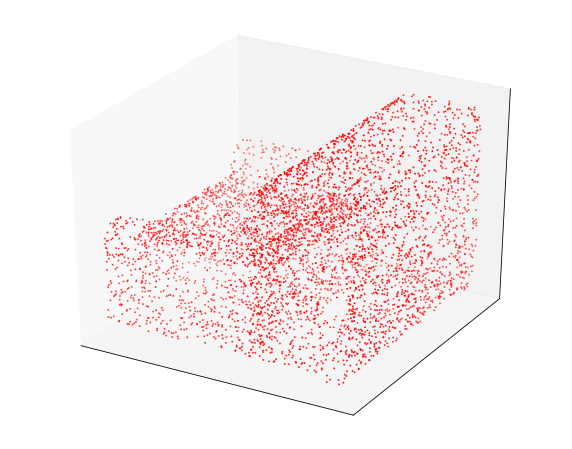

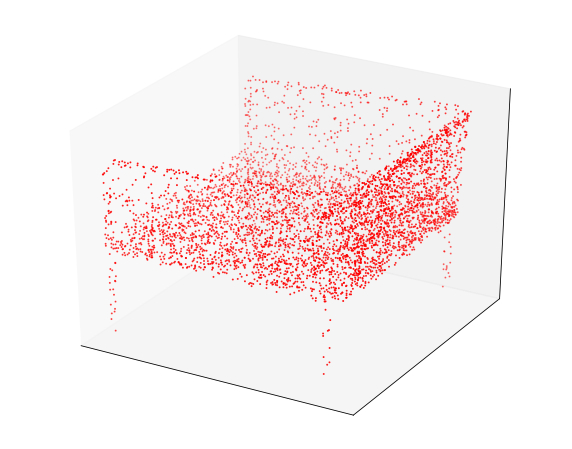

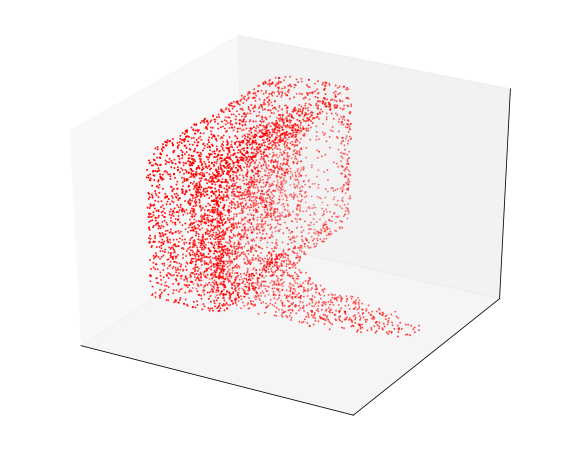

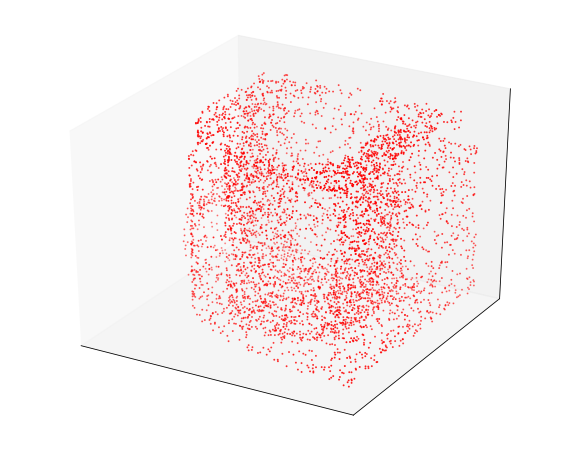

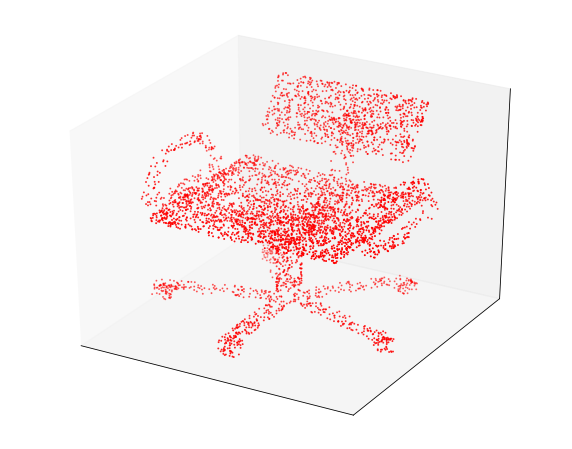

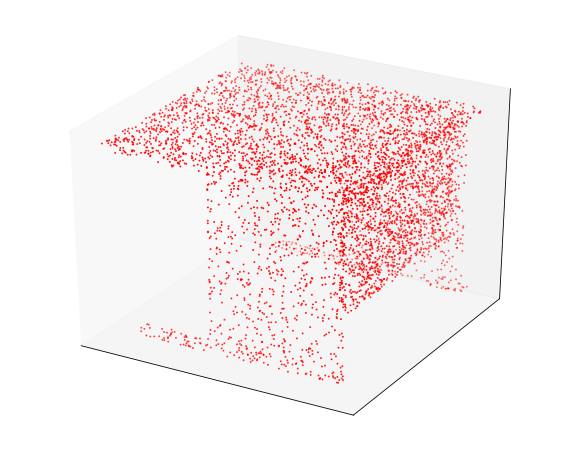

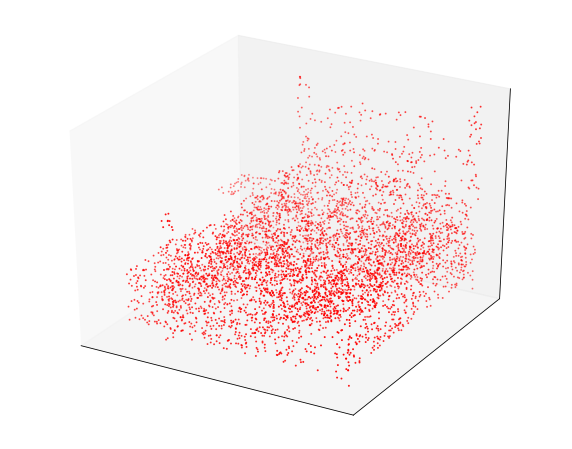

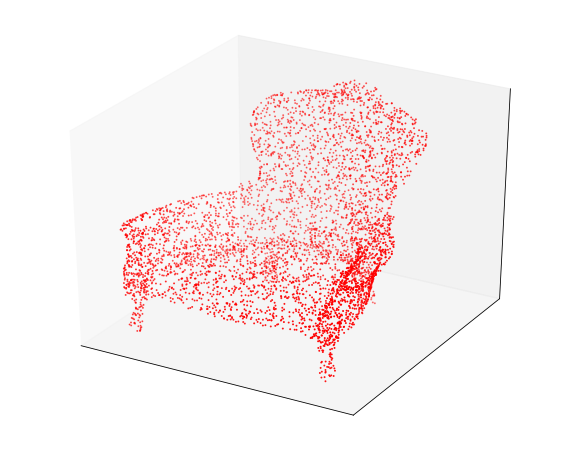

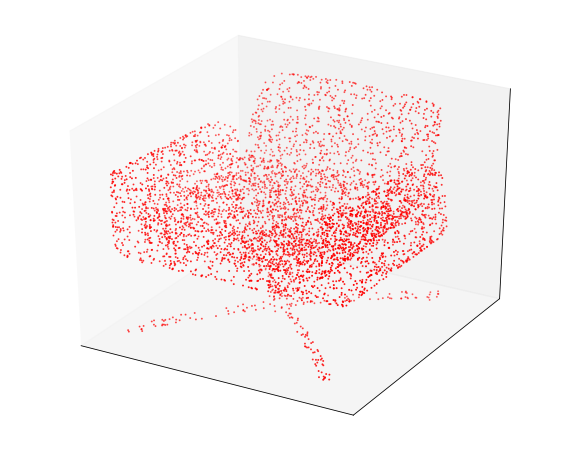

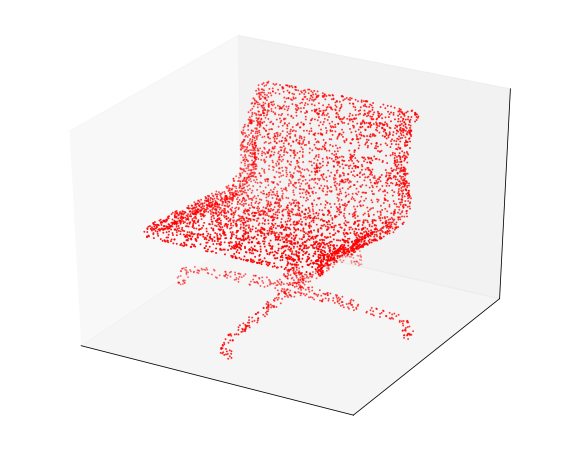

In [42]:
for i in range(10):
    visualize_npy(X_train[i], save_img_fpath=None)

In [43]:
adnet_HP = HyperParameter(lr=0.001, epochs=4)
train_ds = PointDriftDS(X_train, y_train)
test_ds = PointDriftDS(X_test, y_test)

# train autodecoder
mn_autodecoder = train_decoder(adnet_HP, DS, train_ds=train_ds,
                               test_ds=test_ds, save_wt_fname='mnet_decoder.pth')

# get the train encodings
train_encoding_ds = EncodingDS(PointDriftDS(
    X_train, y_train), mn_autodecoder)
train_result = train_encoding_ds.train_encodings(num_iterations=15, lr=0.05)

# get the test encodings
test_encoding_ds = EncodingDS(PointDriftDS(
    X_test, y_test), mn_autodecoder)
test_result = test_encoding_ds.train_encodings(num_iterations=15, lr=0.05)

Epoch: 0. batch_idx: 100
Loss:  5015938.251033173 3801818.335453796
0 3146.6897 tensor(7.2427, device='cuda:0', grad_fn=<NormBackward0>)
0 3223.5452 tensor(7.2477, device='cuda:0', grad_fn=<NormBackward0>)
0 493.40656 tensor(7.2946, device='cuda:0', grad_fn=<NormBackward0>)
0 10457.486 tensor(7.2529, device='cuda:0', grad_fn=<NormBackward0>)
0 97918.96 tensor(7.2273, device='cuda:0', grad_fn=<NormBackward0>)
0 100517.055 tensor(7.3792, device='cuda:0', grad_fn=<NormBackward0>)
0 6317857.5 tensor(7.2373, device='cuda:0', grad_fn=<NormBackward0>)
0 6324899.5 tensor(7.2567, device='cuda:0', grad_fn=<NormBackward0>)
0 2060.6064 tensor(7.2124, device='cuda:0', grad_fn=<NormBackward0>)
0 15305.645 tensor(7.2499, device='cuda:0', grad_fn=<NormBackward0>)
0 3457.7288 tensor(7.2488, device='cuda:0', grad_fn=<NormBackward0>)
0 39615.16 tensor(7.2748, device='cuda:0', grad_fn=<NormBackward0>)
0 5930.4893 tensor(7.2177, device='cuda:0', grad_fn=<NormBackward0>)
0 2119324.5 tensor(7.2991, device='c

0 776.18915 tensor(5.1610, device='cuda:0', grad_fn=<NormBackward0>)
0 19210.09 tensor(5.1174, device='cuda:0', grad_fn=<NormBackward0>)
0 17285.432 tensor(5.0998, device='cuda:0', grad_fn=<NormBackward0>)
0 1765.4823 tensor(5.1016, device='cuda:0', grad_fn=<NormBackward0>)
0 475.27563 tensor(5.1653, device='cuda:0', grad_fn=<NormBackward0>)
0 285249.1 tensor(5.1691, device='cuda:0', grad_fn=<NormBackward0>)
0 279751.97 tensor(5.1192, device='cuda:0', grad_fn=<NormBackward0>)
0 1122.3336 tensor(5.1479, device='cuda:0', grad_fn=<NormBackward0>)
0 326693.7 tensor(5.1307, device='cuda:0', grad_fn=<NormBackward0>)
0 347.05054 tensor(5.0452, device='cuda:0', grad_fn=<NormBackward0>)
0 3771657.8 tensor(5.1031, device='cuda:0', grad_fn=<NormBackward0>)
0 324021.16 tensor(5.1074, device='cuda:0', grad_fn=<NormBackward0>)
0 389670.7 tensor(5.1429, device='cuda:0', grad_fn=<NormBackward0>)
0 3002.163 tensor(5.1326, device='cuda:0', grad_fn=<NormBackward0>)
0 1881.2573 tensor(5.1815, device='cuda

0 1002.01044 tensor(5.1478, device='cuda:0', grad_fn=<NormBackward0>)
0 1430.1355 tensor(5.1429, device='cuda:0', grad_fn=<NormBackward0>)
0 403011.2 tensor(5.1561, device='cuda:0', grad_fn=<NormBackward0>)
0 1380.3508 tensor(5.1220, device='cuda:0', grad_fn=<NormBackward0>)
0 688.47955 tensor(5.1464, device='cuda:0', grad_fn=<NormBackward0>)
0 2053876.0 tensor(5.2077, device='cuda:0', grad_fn=<NormBackward0>)
0 6916.0815 tensor(5.1359, device='cuda:0', grad_fn=<NormBackward0>)
0 3427441.8 tensor(5.1413, device='cuda:0', grad_fn=<NormBackward0>)
0 556.1846 tensor(5.0535, device='cuda:0', grad_fn=<NormBackward0>)
0 13881.198 tensor(5.1073, device='cuda:0', grad_fn=<NormBackward0>)
0 289.4592 tensor(5.1677, device='cuda:0', grad_fn=<NormBackward0>)
0 215.5268 tensor(5.1406, device='cuda:0', grad_fn=<NormBackward0>)
0 287.33005 tensor(5.1536, device='cuda:0', grad_fn=<NormBackward0>)
0 1051.0999 tensor(5.1049, device='cuda:0', grad_fn=<NormBackward0>)
0 1674.7152 tensor(5.1116, device='cu

0 2083.1 tensor(5.1675, device='cuda:0', grad_fn=<NormBackward0>)
0 176.07327 tensor(5.1020, device='cuda:0', grad_fn=<NormBackward0>)
0 2529025.5 tensor(5.1044, device='cuda:0', grad_fn=<NormBackward0>)
0 51830508.0 tensor(5.1783, device='cuda:0', grad_fn=<NormBackward0>)
0 753.95966 tensor(5.1122, device='cuda:0', grad_fn=<NormBackward0>)
0 512.54736 tensor(5.1054, device='cuda:0', grad_fn=<NormBackward0>)
0 342.21146 tensor(5.1024, device='cuda:0', grad_fn=<NormBackward0>)
0 13553.906 tensor(5.1398, device='cuda:0', grad_fn=<NormBackward0>)
0 44677.973 tensor(5.0909, device='cuda:0', grad_fn=<NormBackward0>)
0 630.6498 tensor(5.1091, device='cuda:0', grad_fn=<NormBackward0>)
0 2781.9922 tensor(5.1319, device='cuda:0', grad_fn=<NormBackward0>)
0 7835.5103 tensor(5.1159, device='cuda:0', grad_fn=<NormBackward0>)
0 382723.4 tensor(5.1138, device='cuda:0', grad_fn=<NormBackward0>)
0 1524.4371 tensor(5.1113, device='cuda:0', grad_fn=<NormBackward0>)
0 1559.9834 tensor(5.2019, device='cud

0 12082.518 tensor(5.2054, device='cuda:0', grad_fn=<NormBackward0>)
0 3146.7214 tensor(5.0739, device='cuda:0', grad_fn=<NormBackward0>)
0 869.3872 tensor(5.1742, device='cuda:0', grad_fn=<NormBackward0>)
0 3472.0225 tensor(5.0986, device='cuda:0', grad_fn=<NormBackward0>)
0 752.5001 tensor(5.1085, device='cuda:0', grad_fn=<NormBackward0>)
0 50947820.0 tensor(5.1150, device='cuda:0', grad_fn=<NormBackward0>)
0 476272.06 tensor(5.1214, device='cuda:0', grad_fn=<NormBackward0>)
0 237.62436 tensor(5.1005, device='cuda:0', grad_fn=<NormBackward0>)
0 990.6891 tensor(5.1339, device='cuda:0', grad_fn=<NormBackward0>)
0 5224.9043 tensor(5.1947, device='cuda:0', grad_fn=<NormBackward0>)
0 7304.1377 tensor(5.1435, device='cuda:0', grad_fn=<NormBackward0>)
0 351.701 tensor(5.1581, device='cuda:0', grad_fn=<NormBackward0>)
0 162.85985 tensor(5.1613, device='cuda:0', grad_fn=<NormBackward0>)
0 10139.51 tensor(5.1513, device='cuda:0', grad_fn=<NormBackward0>)
0 435.9679 tensor(5.1345, device='cuda:

0 125.078354 tensor(5.1968, device='cuda:0', grad_fn=<NormBackward0>)
0 1544.4666 tensor(5.1015, device='cuda:0', grad_fn=<NormBackward0>)
0 1590.3458 tensor(5.2143, device='cuda:0', grad_fn=<NormBackward0>)
0 3007.9597 tensor(5.0859, device='cuda:0', grad_fn=<NormBackward0>)
0 1561.1655 tensor(5.1415, device='cuda:0', grad_fn=<NormBackward0>)
0 3230.176 tensor(5.1514, device='cuda:0', grad_fn=<NormBackward0>)
0 172.04637 tensor(5.0853, device='cuda:0', grad_fn=<NormBackward0>)
0 2743.7815 tensor(5.1556, device='cuda:0', grad_fn=<NormBackward0>)
0 34664.555 tensor(5.1147, device='cuda:0', grad_fn=<NormBackward0>)
0 4166.3726 tensor(5.1384, device='cuda:0', grad_fn=<NormBackward0>)
0 18639.543 tensor(5.0825, device='cuda:0', grad_fn=<NormBackward0>)
0 1147.5042 tensor(5.1545, device='cuda:0', grad_fn=<NormBackward0>)
0 3454.0308 tensor(5.1132, device='cuda:0', grad_fn=<NormBackward0>)
0 314.53143 tensor(5.1389, device='cuda:0', grad_fn=<NormBackward0>)
0 408.78674 tensor(5.2148, device=

In [44]:
# train the compnet
HP = HyperParameter(epochs=20, batch_size=16, lr=0.001)
mn_compnet = train_compnet(HP, DS,
                           train_ds=train_encoding_ds, test_ds=test_encoding_ds,
                           save_wt_fname='mnet_compnet.pth',)

Epoch: 0. batch_idx: 100
Loss:  0.6094199758768082 0.7586817085742951
Epoch: 0. batch_idx: 200
Loss:  0.6341352450847626 0.7078851348161698
------------------ Evaluation Report ------------------
Total Accuracy: 0.6112334801762115
After 57 batches and 908 test points

Metrics for the same class:
Avg loss: 0.5908820362467515
Precision: 0.5796529968454258
Recall: 0.8094713656387665
F1 Score: 0.6755514705882354

Metrics for the diff class:
Avg loss: 0.722337005431192
Precision: 0.6843065693430657
Recall: 0.4129955947136564
F1 Score: 0.5151098901098902
Eval:  (33.680276066064835, 41.17320930957794, 735.0, 375.0, 173.0, 533.0, 57, 908)
Epoch: 1. batch_idx: 100
Loss:  0.6578540050983429 0.6837487578392029
Epoch: 1. batch_idx: 200
Loss:  0.6382591840624809 0.6642682617902755
Epoch: 2. batch_idx: 100
Loss:  0.6527281475067138 0.6634863859415054
Epoch: 2. batch_idx: 200
Loss:  0.6470188906788826 0.6559618297219276
Epoch: 3. batch_idx: 100
Loss:  0.6525438204407692 0.654444625377655
Epoch: 3. ba

### Single CompNet result on ModelNet10 Data

In [45]:
# evaluate compnet
eval_compnet(mn_compnet, test_encoding_ds)

------------------ Evaluation Report ------------------
Total Accuracy: 0.6426211453744494
After 57 batches and 908 test points

Metrics for the same class:
Avg loss: 0.5950816153434285
Precision: 0.610968294772922
Recall: 0.7852422907488987
F1 Score: 0.6872289156626507

Metrics for the diff class:
Avg loss: 0.6797649651242975
Precision: 0.699537750385208
Recall: 0.5
F1 Score: 0.5831727681438664


(33.919652074575424, 38.74660301208496, 713.0, 454.0, 195.0, 454.0, 57, 908)

### Train Ensemble CompNet1 on ModelNet10 Data

In [46]:
ensemble_HP = HyperParameter(epochs=20, batch_size=16, lr=0.001)

# Train with the ensemble net
ensemble1 = train_compnet(ensemble_HP, DS,
                           train_ds=train_encoding_ds,
                           test_ds=test_encoding_ds,
                           save_wt_fname='mnet_ensemble1.pth',
                           compnet=EnsembleCompNet())

Epoch: 0. batch_idx: 100
Loss:  0.8242730617523193 0.5911899954080582
Epoch: 0. batch_idx: 200
Loss:  0.7002114725112915 0.6837494868040085
------------------ Evaluation Report ------------------
Total Accuracy: 0.5655286343612335
After 57 batches and 908 test points

Metrics for the same class:
Avg loss: 0.6436040830193904
Precision: 0.5414057063326374
Recall: 0.8568281938325991
F1 Score: 0.6635394456289979

Metrics for the diff class:
Avg loss: 0.7327337087246409
Precision: 0.6569920844327177
Recall: 0.27422907488986786
F1 Score: 0.38694638694638694
Eval:  (36.685432732105255, 41.765821397304535, 778.0, 249.0, 130.0, 659.0, 57, 908)
Epoch: 1. batch_idx: 100
Loss:  0.6451846081018447 0.7432462108135224
Epoch: 1. batch_idx: 200
Loss:  0.6361449581384658 0.7336730074882507
Epoch: 2. batch_idx: 100
Loss:  0.6196840709447861 0.7410952734947205
Epoch: 2. batch_idx: 200
Loss:  0.5991337120532989 0.7360696297883987
Epoch: 3. batch_idx: 100
Loss:  0.5820208746194839 0.7301737970113754
Epoch: 

### Evaluate Ensemble CompNet1 on ModelNet10 Data

In [47]:
eval_compnet(ensemble1, test_encoding_ds)

------------------ Evaluation Report ------------------
Total Accuracy: 0.7648678414096917
After 57 batches and 908 test points

Metrics for the same class:
Avg loss: 0.390854876815227
Precision: 0.7200365965233303
Recall: 0.8667400881057269
F1 Score: 0.7866066966516743

Metrics for the diff class:
Avg loss: 0.6377554603835993
Precision: 0.8326417704011065
Recall: 0.6629955947136564
F1 Score: 0.7381974248927039


(22.27872797846794, 36.35206124186516, 787.0, 602.0, 121.0, 306.0, 57, 908)

# Training out autodecoder and Ensemble CompNets on ModelNet40 data with 33 classes

In [26]:
# Load the X_train, X_test, y_train, y_test after reading from the .npy file in the disk
train40 = './data/ModelNet40_train_npy/'
test40 = './data/ModelNet40_test_npy/'

# Warning: The train and test directories must have the same number of files
X_train40, y_train40 = get_X_y_from_npy(train40, 100)
X_test40, y_test40 = get_X_y_from_npy(test40, 100)

X_train40.shape, X_test40.shape, y_train40.shape, y_test40.shape

Adding data/ModelNet40_train_npy/modelnet_flower_pot.npy to X. X is now (149, 5000, 3)
Adding data/ModelNet40_train_npy/modelnet_tv_stand.npy to X. X is now (416, 5000, 3)
Adding data/ModelNet40_train_npy/modelnet_mantel.npy to X. X is now (700, 5000, 3)
Adding data/ModelNet40_train_npy/modelnet_tent.npy to X. X is now (863, 5000, 3)
Adding data/ModelNet40_train_npy/modelnet_chair.npy to X. X is now (1752, 5000, 3)
Adding data/ModelNet40_train_npy/modelnet_airplane.npy to X. X is now (2378, 5000, 3)
Adding data/ModelNet40_train_npy/modelnet_keyboard.npy to X. X is now (2523, 5000, 3)
Adding data/ModelNet40_train_npy/modelnet_person.npy to X. X is now (2611, 5000, 3)
Adding data/ModelNet40_train_npy/modelnet_bowl.npy to X. X is now (2675, 5000, 3)
Adding data/ModelNet40_train_npy/modelnet_door.npy to X. X is now (2784, 5000, 3)
Adding data/ModelNet40_train_npy/modelnet_lamp.npy to X. X is now (2908, 5000, 3)
Adding data/ModelNet40_train_npy/modelnet_xbox.npy to X. X is now (3011, 5000, 

((7598, 5000, 3), (1860, 5000, 3), (7598, 1), (1860, 1))

## Looking at ModelNet40 3D images

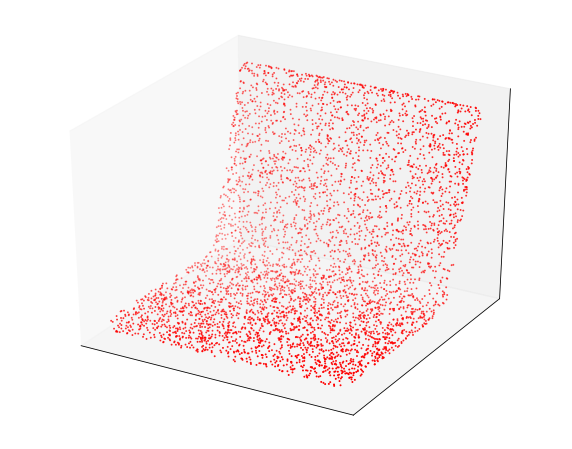

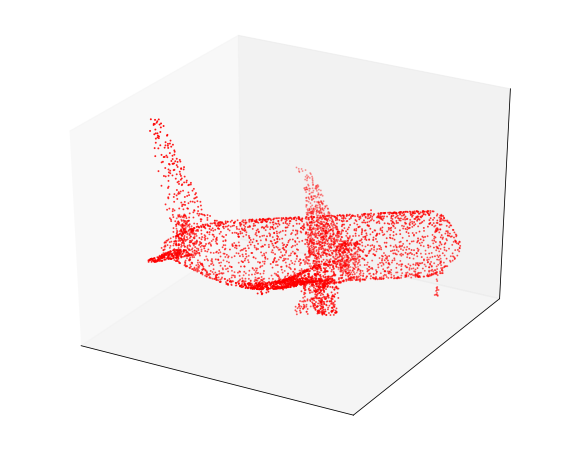

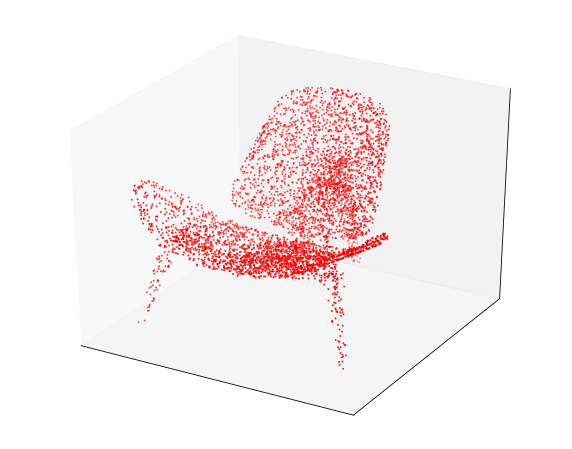

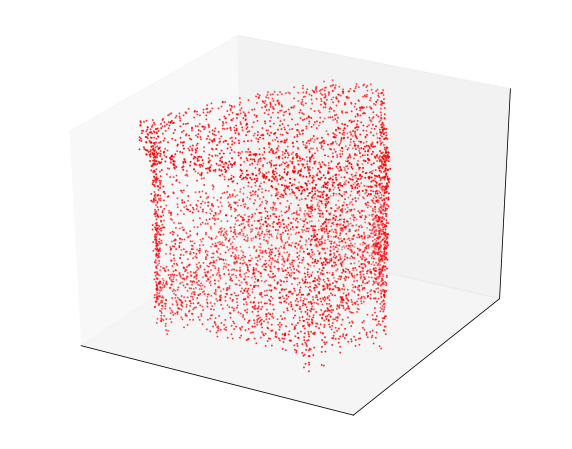

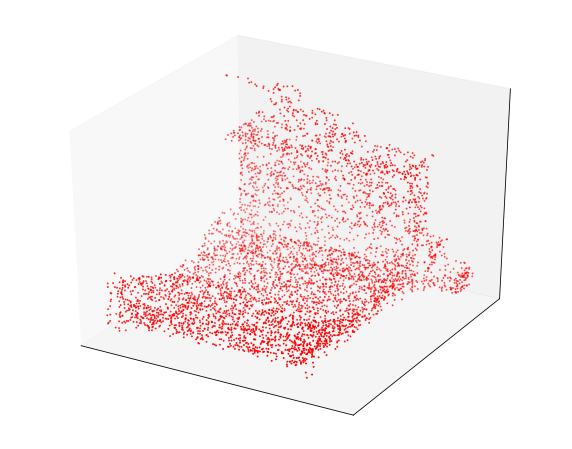

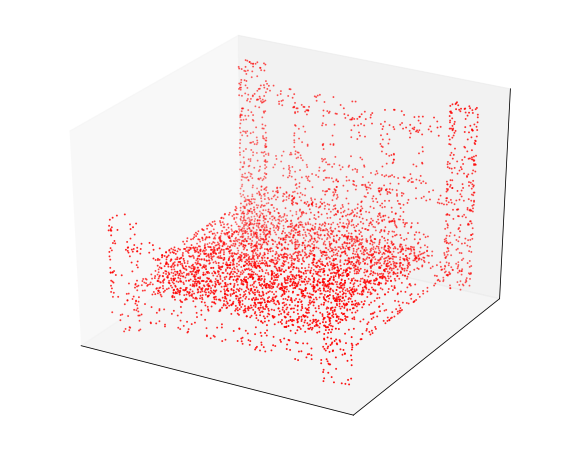

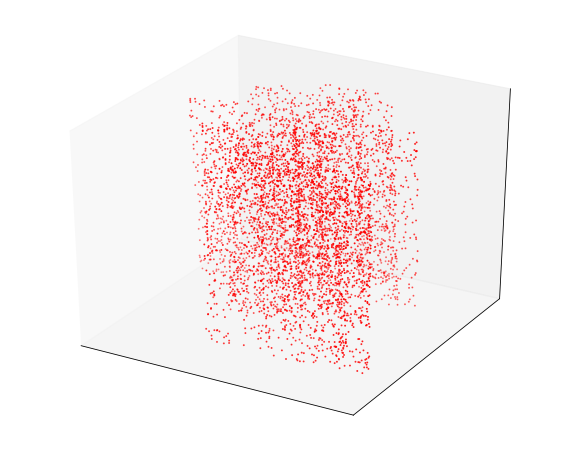

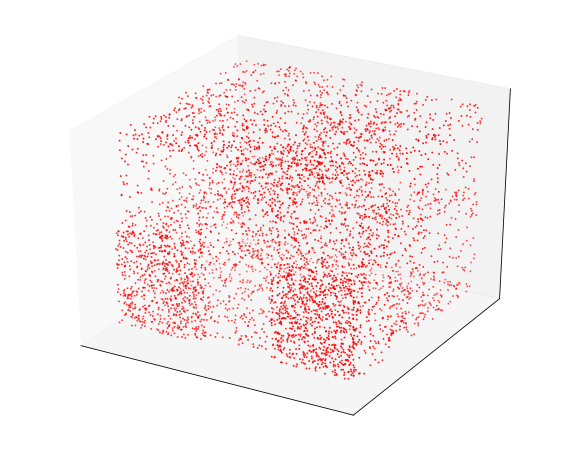

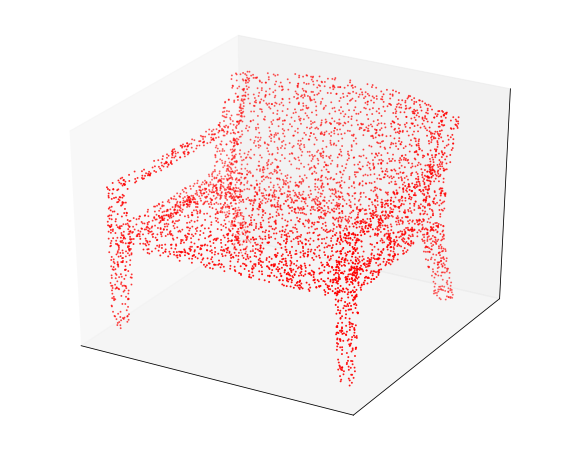

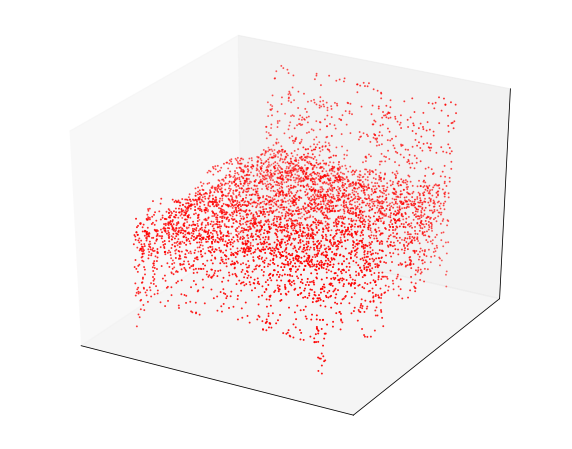

In [28]:
for i in range(10):
    visualize_npy(X_train40[i], save_img_fpath=f'./img/modelnet40_{i}.png')

## Training the autodecoder and generating the latent space encodings

In [29]:
adnet_HP40 = HyperParameter(lr=0.001, epochs=4)
train_ds40 = PointDriftDS(X_train40, y_train40)
test_ds40 = PointDriftDS(X_test40, y_test40)

# train autodecoder
mn40_autodecoder = train_decoder(adnet_HP40, DS, train_ds=train_ds40,
                               test_ds=test_ds40, save_wt_fname='mnet40_decoder.pth')

# get the train encodings
train_encoding_ds40 = EncodingDS(PointDriftDS(
    X_train40, y_train40), mn40_autodecoder)
train_result40 = train_encoding_ds40.train_encodings(num_iterations=15, lr=0.05)

# get the test encodings
test_encoding_ds40 = EncodingDS(PointDriftDS(
    X_test40, y_test40), mn40_autodecoder)
test_result40 = test_encoding_ds40.train_encodings(num_iterations=15, lr=0.05)

Epoch: 0. batch_idx: 100
Loss:  86324044443.20941 85138882920.23282
Epoch: 0. batch_idx: 200
Loss:  16746996648650.266 16836227234209.332
0 1622997.1 tensor(7.2848, device='cuda:0', grad_fn=<NormBackward0>)
0 2621187.8 tensor(7.3053, device='cuda:0', grad_fn=<NormBackward0>)
0 358480480.0 tensor(7.2937, device='cuda:0', grad_fn=<NormBackward0>)
0 5431981600.0 tensor(7.2434, device='cuda:0', grad_fn=<NormBackward0>)
0 2094863000.0 tensor(7.2330, device='cuda:0', grad_fn=<NormBackward0>)
0 3222735.5 tensor(7.2945, device='cuda:0', grad_fn=<NormBackward0>)
0 25776434.0 tensor(7.2462, device='cuda:0', grad_fn=<NormBackward0>)
0 5838097.0 tensor(7.2054, device='cuda:0', grad_fn=<NormBackward0>)
0 74170.46 tensor(7.2289, device='cuda:0', grad_fn=<NormBackward0>)
0 3893157.5 tensor(7.1888, device='cuda:0', grad_fn=<NormBackward0>)
0 7765265400.0 tensor(7.2800, device='cuda:0', grad_fn=<NormBackward0>)
0 8469867.0 tensor(7.2397, device='cuda:0', grad_fn=<NormBackward0>)
0 1200646.6 tensor(7.23

0 1810246.4 tensor(2.6103, device='cuda:0', grad_fn=<NormBackward0>)
0 231590.05 tensor(2.5927, device='cuda:0', grad_fn=<NormBackward0>)
Encodings trained
Eval:  (2286438471.993975, 1588564678.6573093)
Epoch: 1. batch_idx: 100
Loss:  5095048116.669609 1978824609.9517188
Epoch: 1. batch_idx: 200
Loss:  12543048446557.607 12543392696052.867
Epoch: 2. batch_idx: 100
Loss:  5581409856.77541 90012647219.86523
Epoch: 2. batch_idx: 200
Loss:  2525050227505.7485 2525390802660.3394
Epoch: 3. batch_idx: 100
Loss:  35026667355.330315 122022234098.93678
Epoch: 3. batch_idx: 200
Loss:  3762527912.4692187 1383404927.7980468
0 235187.69 tensor(5.0477, device='cuda:0', grad_fn=<NormBackward0>)
0 604710.3 tensor(5.1052, device='cuda:0', grad_fn=<NormBackward0>)
0 473413.5 tensor(5.0750, device='cuda:0', grad_fn=<NormBackward0>)
0 168729.38 tensor(5.0054, device='cuda:0', grad_fn=<NormBackward0>)
0 3237331.2 tensor(5.1171, device='cuda:0', grad_fn=<NormBackward0>)
0 3074490.2 tensor(5.0928, device='cud

0 94685816.0 tensor(5.0775, device='cuda:0', grad_fn=<NormBackward0>)
0 393757.7 tensor(5.1214, device='cuda:0', grad_fn=<NormBackward0>)
0 273080580.0 tensor(5.1006, device='cuda:0', grad_fn=<NormBackward0>)
0 42513.008 tensor(5.0059, device='cuda:0', grad_fn=<NormBackward0>)
0 57073332.0 tensor(5.1386, device='cuda:0', grad_fn=<NormBackward0>)
0 73855.12 tensor(5.1241, device='cuda:0', grad_fn=<NormBackward0>)
0 39920.957 tensor(5.1525, device='cuda:0', grad_fn=<NormBackward0>)
0 91513.62 tensor(5.0688, device='cuda:0', grad_fn=<NormBackward0>)
0 6015317.5 tensor(5.1322, device='cuda:0', grad_fn=<NormBackward0>)
0 603051.56 tensor(5.0191, device='cuda:0', grad_fn=<NormBackward0>)
0 95656.22 tensor(5.0959, device='cuda:0', grad_fn=<NormBackward0>)
0 354340.5 tensor(5.0008, device='cuda:0', grad_fn=<NormBackward0>)
0 306048.22 tensor(5.0859, device='cuda:0', grad_fn=<NormBackward0>)
0 619012.25 tensor(5.0635, device='cuda:0', grad_fn=<NormBackward0>)
0 10111180.0 tensor(5.0786, device=

0 24410788.0 tensor(5.0954, device='cuda:0', grad_fn=<NormBackward0>)
0 15332789.0 tensor(5.0889, device='cuda:0', grad_fn=<NormBackward0>)
0 567933.44 tensor(5.2227, device='cuda:0', grad_fn=<NormBackward0>)
0 2637197.0 tensor(5.0649, device='cuda:0', grad_fn=<NormBackward0>)
0 52017940.0 tensor(5.1676, device='cuda:0', grad_fn=<NormBackward0>)
0 138422.62 tensor(5.1744, device='cuda:0', grad_fn=<NormBackward0>)
0 738096.8 tensor(5.1448, device='cuda:0', grad_fn=<NormBackward0>)
0 24568976.0 tensor(5.0311, device='cuda:0', grad_fn=<NormBackward0>)
0 24114658.0 tensor(5.0158, device='cuda:0', grad_fn=<NormBackward0>)
0 166695060.0 tensor(5.1040, device='cuda:0', grad_fn=<NormBackward0>)
0 74907950000.0 tensor(5.0700, device='cuda:0', grad_fn=<NormBackward0>)
0 41684610.0 tensor(5.1073, device='cuda:0', grad_fn=<NormBackward0>)
0 67792.65 tensor(5.0798, device='cuda:0', grad_fn=<NormBackward0>)
0 17588241000000.0 tensor(5.1639, device='cuda:0', grad_fn=<NormBackward0>)
0 157666.17 tenso

0 2097994600.0 tensor(5.1140, device='cuda:0', grad_fn=<NormBackward0>)
0 237948.52 tensor(5.0443, device='cuda:0', grad_fn=<NormBackward0>)
0 10788093.0 tensor(5.0478, device='cuda:0', grad_fn=<NormBackward0>)
0 4709177.0 tensor(5.1786, device='cuda:0', grad_fn=<NormBackward0>)
0 9363101000.0 tensor(5.1381, device='cuda:0', grad_fn=<NormBackward0>)
0 359376.16 tensor(5.0970, device='cuda:0', grad_fn=<NormBackward0>)
0 288370.9 tensor(5.0960, device='cuda:0', grad_fn=<NormBackward0>)
0 76100.62 tensor(5.1398, device='cuda:0', grad_fn=<NormBackward0>)
0 237976.73 tensor(5.1288, device='cuda:0', grad_fn=<NormBackward0>)
0 834031.4 tensor(5.1458, device='cuda:0', grad_fn=<NormBackward0>)
0 2550234.0 tensor(5.0922, device='cuda:0', grad_fn=<NormBackward0>)
0 24923.307 tensor(5.1313, device='cuda:0', grad_fn=<NormBackward0>)
0 426284.2 tensor(5.0386, device='cuda:0', grad_fn=<NormBackward0>)
0 143373380.0 tensor(5.0814, device='cuda:0', grad_fn=<NormBackward0>)
0 143521460.0 tensor(5.0791, 

0 2473870.2 tensor(5.2168, device='cuda:0', grad_fn=<NormBackward0>)
0 2347775.8 tensor(5.0517, device='cuda:0', grad_fn=<NormBackward0>)
0 118226.91 tensor(5.0698, device='cuda:0', grad_fn=<NormBackward0>)
0 268966.47 tensor(5.1747, device='cuda:0', grad_fn=<NormBackward0>)
0 162265.88 tensor(5.1002, device='cuda:0', grad_fn=<NormBackward0>)
0 364176.72 tensor(5.0896, device='cuda:0', grad_fn=<NormBackward0>)
0 82090.484 tensor(5.1573, device='cuda:0', grad_fn=<NormBackward0>)
0 113163.27 tensor(5.0567, device='cuda:0', grad_fn=<NormBackward0>)
0 640768.9 tensor(5.0438, device='cuda:0', grad_fn=<NormBackward0>)
0 3942785.8 tensor(5.1365, device='cuda:0', grad_fn=<NormBackward0>)
0 424915.0 tensor(5.0721, device='cuda:0', grad_fn=<NormBackward0>)
0 2302406400.0 tensor(5.1164, device='cuda:0', grad_fn=<NormBackward0>)
0 207891.58 tensor(5.0792, device='cuda:0', grad_fn=<NormBackward0>)
0 150372.2 tensor(5.1105, device='cuda:0', grad_fn=<NormBackward0>)
0 2058749.1 tensor(5.0955, device=

0 32949040000.0 tensor(5.1431, device='cuda:0', grad_fn=<NormBackward0>)
0 96122936.0 tensor(5.0400, device='cuda:0', grad_fn=<NormBackward0>)
0 26604490.0 tensor(5.1304, device='cuda:0', grad_fn=<NormBackward0>)
0 511080.4 tensor(5.0563, device='cuda:0', grad_fn=<NormBackward0>)
0 531978.44 tensor(5.1907, device='cuda:0', grad_fn=<NormBackward0>)
0 64870240.0 tensor(5.1174, device='cuda:0', grad_fn=<NormBackward0>)
0 151941.88 tensor(4.9926, device='cuda:0', grad_fn=<NormBackward0>)
0 86002.56 tensor(5.0246, device='cuda:0', grad_fn=<NormBackward0>)
0 107442.06 tensor(5.1178, device='cuda:0', grad_fn=<NormBackward0>)
0 1645545.1 tensor(5.1038, device='cuda:0', grad_fn=<NormBackward0>)
0 234259.38 tensor(4.9998, device='cuda:0', grad_fn=<NormBackward0>)
0 15266.9 tensor(5.1343, device='cuda:0', grad_fn=<NormBackward0>)
0 50776.555 tensor(5.0544, device='cuda:0', grad_fn=<NormBackward0>)
0 20507.234 tensor(5.0635, device='cuda:0', grad_fn=<NormBackward0>)
0 135848.53 tensor(5.1237, devi

0 897077400000000.0 tensor(5.1317, device='cuda:0', grad_fn=<NormBackward0>)
0 897074300000000.0 tensor(5.1400, device='cuda:0', grad_fn=<NormBackward0>)
0 44787.2 tensor(5.1258, device='cuda:0', grad_fn=<NormBackward0>)
0 185711.88 tensor(5.1275, device='cuda:0', grad_fn=<NormBackward0>)
0 8462520.0 tensor(5.1853, device='cuda:0', grad_fn=<NormBackward0>)
0 8652019.0 tensor(5.1327, device='cuda:0', grad_fn=<NormBackward0>)
0 133033420.0 tensor(5.2032, device='cuda:0', grad_fn=<NormBackward0>)
0 161313300.0 tensor(5.0706, device='cuda:0', grad_fn=<NormBackward0>)
0 15914.571 tensor(5.0558, device='cuda:0', grad_fn=<NormBackward0>)
0 65911770.0 tensor(5.1592, device='cuda:0', grad_fn=<NormBackward0>)
0 49975.027 tensor(5.0934, device='cuda:0', grad_fn=<NormBackward0>)
0 197641.72 tensor(5.1098, device='cuda:0', grad_fn=<NormBackward0>)
0 216293.4 tensor(5.1846, device='cuda:0', grad_fn=<NormBackward0>)
0 171707.69 tensor(5.1428, device='cuda:0', grad_fn=<NormBackward0>)
0 114376.484 ten

0 326461.72 tensor(5.0786, device='cuda:0', grad_fn=<NormBackward0>)
0 476953.56 tensor(5.0471, device='cuda:0', grad_fn=<NormBackward0>)
0 524816300.0 tensor(5.0993, device='cuda:0', grad_fn=<NormBackward0>)
0 12738.451 tensor(5.1503, device='cuda:0', grad_fn=<NormBackward0>)
0 89072.84 tensor(5.0814, device='cuda:0', grad_fn=<NormBackward0>)
0 118765.836 tensor(5.1130, device='cuda:0', grad_fn=<NormBackward0>)
0 2962.4783 tensor(5.0931, device='cuda:0', grad_fn=<NormBackward0>)
0 74866.65 tensor(5.0791, device='cuda:0', grad_fn=<NormBackward0>)
0 391211.1 tensor(5.1557, device='cuda:0', grad_fn=<NormBackward0>)
0 898994.56 tensor(5.0179, device='cuda:0', grad_fn=<NormBackward0>)
0 22626.055 tensor(5.0255, device='cuda:0', grad_fn=<NormBackward0>)
0 22862486.0 tensor(5.0310, device='cuda:0', grad_fn=<NormBackward0>)
0 262242.25 tensor(5.0592, device='cuda:0', grad_fn=<NormBackward0>)
0 695991.06 tensor(5.0799, device='cuda:0', grad_fn=<NormBackward0>)
0 76031670.0 tensor(5.1104, devic

0 92722.03 tensor(5.1917, device='cuda:0', grad_fn=<NormBackward0>)
0 35415.94 tensor(5.1858, device='cuda:0', grad_fn=<NormBackward0>)
0 205484.27 tensor(5.1623, device='cuda:0', grad_fn=<NormBackward0>)
0 9321491000.0 tensor(5.1825, device='cuda:0', grad_fn=<NormBackward0>)
0 346539.22 tensor(5.1663, device='cuda:0', grad_fn=<NormBackward0>)
0 285544.3 tensor(5.0931, device='cuda:0', grad_fn=<NormBackward0>)
0 301934.25 tensor(5.1717, device='cuda:0', grad_fn=<NormBackward0>)
0 1267099.0 tensor(4.7566, device='cuda:0', grad_fn=<NormBackward0>)
0 194239.03 tensor(4.7877, device='cuda:0', grad_fn=<NormBackward0>)
Encodings trained
0 502458.22 tensor(5.0828, device='cuda:0', grad_fn=<NormBackward0>)
0 452478.75 tensor(5.0534, device='cuda:0', grad_fn=<NormBackward0>)
0 698702.75 tensor(5.1534, device='cuda:0', grad_fn=<NormBackward0>)
0 860939.94 tensor(5.1440, device='cuda:0', grad_fn=<NormBackward0>)
0 421604670.0 tensor(5.1730, device='cuda:0', grad_fn=<NormBackward0>)
0 425540450.0 

0 190730.11 tensor(5.1507, device='cuda:0', grad_fn=<NormBackward0>)
0 13719617.0 tensor(5.1498, device='cuda:0', grad_fn=<NormBackward0>)
0 302244.28 tensor(5.1535, device='cuda:0', grad_fn=<NormBackward0>)
0 916394.25 tensor(5.0745, device='cuda:0', grad_fn=<NormBackward0>)
0 1016066.44 tensor(5.1328, device='cuda:0', grad_fn=<NormBackward0>)
0 8650223.0 tensor(5.0608, device='cuda:0', grad_fn=<NormBackward0>)
0 10607745.0 tensor(5.0756, device='cuda:0', grad_fn=<NormBackward0>)
0 91258.805 tensor(5.1971, device='cuda:0', grad_fn=<NormBackward0>)
0 174063.25 tensor(5.1441, device='cuda:0', grad_fn=<NormBackward0>)
0 81280.055 tensor(5.0138, device='cuda:0', grad_fn=<NormBackward0>)
0 88925.24 tensor(5.0293, device='cuda:0', grad_fn=<NormBackward0>)
0 35315560000.0 tensor(5.0769, device='cuda:0', grad_fn=<NormBackward0>)
0 23735480000.0 tensor(5.1269, device='cuda:0', grad_fn=<NormBackward0>)
0 10132307000.0 tensor(5.1740, device='cuda:0', grad_fn=<NormBackward0>)
0 77494.33 tensor(5.

0 4900747.0 tensor(5.0947, device='cuda:0', grad_fn=<NormBackward0>)
0 1128544.2 tensor(5.0819, device='cuda:0', grad_fn=<NormBackward0>)
0 10794689.0 tensor(5.1676, device='cuda:0', grad_fn=<NormBackward0>)
0 159621.4 tensor(5.1150, device='cuda:0', grad_fn=<NormBackward0>)
0 7861619.0 tensor(5.0715, device='cuda:0', grad_fn=<NormBackward0>)
0 43481220.0 tensor(2.5818, device='cuda:0', grad_fn=<NormBackward0>)
0 388119.78 tensor(2.5777, device='cuda:0', grad_fn=<NormBackward0>)
Encodings trained


## Train a single CompNet for classification on the ModelNet40 data

In [43]:
# train the compnet
compnet_HP40 = HyperParameter(epochs=50, batch_size=16, lr=0.001)
mn40_compnet = train_compnet(compnet_HP40, DS,
                           train_ds=train_encoding_ds40, test_ds=test_encoding_ds40,
                           save_wt_fname='mnet40_compnet.pth',)

Epoch: 0. batch_idx: 100
Loss:  0.6706315255165101 0.6651436066627503
Epoch: 0. batch_idx: 200
Loss:  0.6579265969991684 0.650756966471672
Epoch: 0. batch_idx: 300
Loss:  0.6485432389378548 0.6508988821506501
Epoch: 0. batch_idx: 400
Loss:  0.646351107954979 0.6419335824251174
------------------ Evaluation Report ------------------
Total Accuracy: 0.5989247311827957
After 117 batches and 1860 test points

Metrics for the same class:
Avg loss: 0.7155416021999131
Precision: 0.6520661157024793
Recall: 0.4241935483870968
F1 Score: 0.5140065146579804

Metrics for the diff class:
Avg loss: 0.610985120646974
Precision: 0.5733067729083665
Recall: 0.7736559139784946
F1 Score: 0.6585812356979406
Eval:  (83.71836745738983, 71.48525911569595, 789.0, 1439.0, 1071.0, 421.0, 117, 1860)
Epoch: 1. batch_idx: 100
Loss:  0.6484219056367874 0.6427287599444389
Epoch: 1. batch_idx: 200
Loss:  0.6458016151189804 0.640463260114193
Epoch: 1. batch_idx: 300
Loss:  0.6455919030308723 0.625073070526123
Epoch: 1. 

Epoch: 21. batch_idx: 200
Loss:  0.5810015547275543 0.572503972351551
Epoch: 21. batch_idx: 300
Loss:  0.5949592995643616 0.5711961448192596
Epoch: 21. batch_idx: 400
Loss:  0.5774470150470734 0.5712430000305175
Epoch: 22. batch_idx: 100
Loss:  0.5934355014562607 0.5704639130830764
Epoch: 22. batch_idx: 200
Loss:  0.5831020200252532 0.5611265882849693
Epoch: 22. batch_idx: 300
Loss:  0.5809882670640946 0.566157263815403
Epoch: 22. batch_idx: 400
Loss:  0.5887716546654701 0.58977654337883
Epoch: 23. batch_idx: 100
Loss:  0.5831681349873543 0.5620106008648872
Epoch: 23. batch_idx: 200
Loss:  0.5901613005995751 0.5683020183444023
Epoch: 23. batch_idx: 300
Loss:  0.5686136493086815 0.5584403815865516
Epoch: 23. batch_idx: 400
Loss:  0.585679449737072 0.5734484279155732
Epoch: 24. batch_idx: 100
Loss:  0.58252920627594 0.5722089436650276
Epoch: 24. batch_idx: 200
Loss:  0.5762372556328773 0.5432990679144859
Epoch: 24. batch_idx: 300
Loss:  0.5779837647080421 0.5725222086906433
Epoch: 24. ba

Epoch: 43. batch_idx: 300
Loss:  0.5450673520565033 0.524986344575882
Epoch: 43. batch_idx: 400
Loss:  0.5338633847236633 0.5282472512125969
Epoch: 44. batch_idx: 100
Loss:  0.5407550457119942 0.51480319917202
Epoch: 44. batch_idx: 200
Loss:  0.5292737996578216 0.5327289789915085
Epoch: 44. batch_idx: 300
Loss:  0.5440478953719139 0.524770148396492
Epoch: 44. batch_idx: 400
Loss:  0.5290664261579514 0.5218536871671676
Epoch: 45. batch_idx: 100
Loss:  0.5529514235258103 0.5357238790392875
Epoch: 45. batch_idx: 200
Loss:  0.5172852373123169 0.5134782510995864
Epoch: 45. batch_idx: 300
Loss:  0.549301110804081 0.5296545347571373
Epoch: 45. batch_idx: 400
Loss:  0.5264385110139846 0.5119366148114204
------------------ Evaluation Report ------------------
Total Accuracy: 0.6115591397849462
After 117 batches and 1860 test points

Metrics for the same class:
Avg loss: 0.7204963172602857
Precision: 0.620569436374201
Recall: 0.5741935483870968
F1 Score: 0.5964814297682213

Metrics for the diff 

### Evaluate Single CompNet on ModelNet40 Data

In [44]:
eval_compnet(mn40_compnet, test_encoding_ds40)

------------------ Evaluation Report ------------------
Total Accuracy: 0.603225806451613
After 117 batches and 1860 test points

Metrics for the same class:
Avg loss: 0.8350983893769419
Precision: 0.6348314606741573
Recall: 0.4860215053763441
F1 Score: 0.5505481120584653

Metrics for the diff class:
Avg loss: 0.5771344566447103
Precision: 0.5836236933797909
Recall: 0.7204301075268817
F1 Score: 0.6448508180943214


(97.7065115571022, 67.5247314274311, 904.0, 1340.0, 956.0, 520.0, 117, 1860)

## Train Ensemble Compnet1 on ModelNet40 data

In [45]:
ensemble_HP40 = HyperParameter(epochs=50, batch_size=16, lr=0.001)

# Train with the ensemble net
ensemble1_40 = train_compnet(ensemble_HP40, DS,
                           train_ds=train_encoding_ds40,
                           test_ds=test_encoding_ds40,
                           save_wt_fname='mnet40_ensemble1.pth',
                           compnet=EnsembleCompNet())

Epoch: 0. batch_idx: 100
Loss:  0.8238329643011093 0.5924645757675171
Epoch: 0. batch_idx: 200
Loss:  0.7154935473203659 0.6690211951732635
Epoch: 0. batch_idx: 300
Loss:  0.6575813513994216 0.7150458943843842
Epoch: 0. batch_idx: 400
Loss:  0.6142687046527863 0.7234216034412384
------------------ Evaluation Report ------------------
Total Accuracy: 0.6204301075268818
After 117 batches and 1860 test points

Metrics for the same class:
Avg loss: 0.5878888707385104
Precision: 0.5934891485809682
Recall: 0.7645161290322581
F1 Score: 0.6682330827067668

Metrics for the diff class:
Avg loss: 0.7293012274636163
Precision: 0.6691842900302115
Recall: 0.47634408602150535
F1 Score: 0.5565326633165829
Eval:  (68.78299787640572, 85.3282436132431, 1422.0, 886.0, 438.0, 974.0, 117, 1860)
Epoch: 1. batch_idx: 100
Loss:  0.5812584012746811 0.7015246212482452
Epoch: 1. batch_idx: 200
Loss:  0.5400733157992363 0.678021132349968
Epoch: 1. batch_idx: 300
Loss:  0.5602761533856392 0.6634456732869148
Epoch: 

Epoch: 21. batch_idx: 100
Loss:  0.43105732979252936 0.4203683602809906
Epoch: 21. batch_idx: 200
Loss:  0.4019203633069992 0.3711982551217079
Epoch: 21. batch_idx: 300
Loss:  0.38831015781499445 0.35303890094161033
Epoch: 21. batch_idx: 400
Loss:  0.392736347084865 0.36663948237895966
Epoch: 22. batch_idx: 100
Loss:  0.4118328478001058 0.3625849413871765
Epoch: 22. batch_idx: 200
Loss:  0.4255896055046469 0.39743453286588193
Epoch: 22. batch_idx: 300
Loss:  0.4249343842919916 0.39701873444020747
Epoch: 22. batch_idx: 400
Loss:  0.39087271576747296 0.33862672701478
Epoch: 23. batch_idx: 100
Loss:  0.4123729960620403 0.38991485558450223
Epoch: 23. batch_idx: 200
Loss:  0.3846948322560638 0.3390611071139574
Epoch: 23. batch_idx: 300
Loss:  0.3853601654805243 0.38345769576728345
Epoch: 23. batch_idx: 400
Loss:  0.3880147504247725 0.37394204035401346
Epoch: 24. batch_idx: 100
Loss:  0.44545300997793674 0.3591653053462505
Epoch: 24. batch_idx: 200
Loss:  0.37661146216094493 0.36576726697385

Epoch: 42. batch_idx: 300
Loss:  0.3540827711042948 0.32620312318205835
Epoch: 42. batch_idx: 400
Loss:  0.3640272863116115 0.29885581977665426
Epoch: 43. batch_idx: 100
Loss:  0.31909137554001066 0.2911474435776472
Epoch: 43. batch_idx: 200
Loss:  0.4161754272133112 0.29233460627496244
Epoch: 43. batch_idx: 300
Loss:  0.33171067013405264 0.30153984621167185
Epoch: 43. batch_idx: 400
Loss:  0.3335988350771368 0.3156319162994623
Epoch: 44. batch_idx: 100
Loss:  0.3441853952407837 0.28568470664322376
Epoch: 44. batch_idx: 200
Loss:  0.37272995575214735 0.2745394487679005
Epoch: 44. batch_idx: 300
Loss:  0.3624931503739208 0.30055277310311795
Epoch: 44. batch_idx: 400
Loss:  0.37045905081089586 0.3474190584570169
Epoch: 45. batch_idx: 100
Loss:  0.34971957762725653 0.3141831398755312
Epoch: 45. batch_idx: 200
Loss:  0.3492181002954021 0.2945318524539471
Epoch: 45. batch_idx: 300
Loss:  0.31466301721520723 0.29244460932910443
Epoch: 45. batch_idx: 400
Loss:  0.33803795317187907 0.297544150

### Evaluate Ensemble CompNet1 on ModelNet40 Data

In [46]:
eval_compnet(ensemble1_40, test_encoding_ds40)

------------------ Evaluation Report ------------------
Total Accuracy: 0.7397849462365591
After 117 batches and 1860 test points

Metrics for the same class:
Avg loss: 0.44892520677202785
Precision: 0.7263959390862944
Recall: 0.7693548387096775
F1 Score: 0.7472584856396867

Metrics for the diff class:
Avg loss: 0.6485624200640581
Precision: 0.7548571428571429
Recall: 0.7102150537634409
F1 Score: 0.7318559556786703


(52.52424919232726, 75.8818031474948, 1431.0, 1321.0, 429.0, 539.0, 117, 1860)